In [1]:
import pickle
import random
import numpy as np

In [2]:
pip install cca-zoo

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
from cca_zoo.models import CCA

In [3]:
def rank(type_embedding , img_embeds, rec_embeds, samples):
    random.seed(42)
    im_vecs = img_embeds 
    instr_vecs = rec_embeds 


    # Sort based on names to always pick same samples for medr
#     idxs = np.argsort(names)
#     names = names[idxs]

    # Ranker
    N = samples
    idxs = range(N)
    
    glob_rank = []
    glob_recall = {1:0.0,5:0.0,10:0.0}
    for i in range(10):

        ids = random.sample(range(0,len(img_embeds)), N)
        im_sub = im_vecs[ids,:]
        instr_sub = instr_vecs[ids,:]
#         ids_sub = names[ids]

        # if params.embedding == 'image':
        if type_embedding == 'image':
            sims = np.dot(im_sub,instr_sub.T) # for im2recipe
        else:
            sims = np.dot(instr_sub,im_sub.T) # for recipe2im

        med_rank = []
        recall = {1:0.0,5:0.0,10:0.0}

        for ii in idxs:

#             name = ids_sub[ii]
            # get a column of similarities
            sim = sims[ii,:]

            # sort indices in descending order
            sorting = np.argsort(sim)[::-1].tolist()

            # find where the index of the pair sample ended up in the sorting
            pos = sorting.index(ii)

            if (pos+1) == 1:
                recall[1]+=1
            if (pos+1) <=5:
                recall[5]+=1
            if (pos+1)<=10:
                recall[10]+=1

            # store the position
            med_rank.append(pos+1)

        for i in recall.keys():
            recall[i]=recall[i]/N

        med = np.median(med_rank)
        # print "median", med

        for i in recall.keys():
            glob_recall[i]+=recall[i]
        glob_rank.append(med)

    for i in glob_recall.keys():
        glob_recall[i] = glob_recall[i]/10

    return np.average(glob_rank), glob_recall

In [4]:
latent_dims=[2,10,50,100,200,500,1000]

In [5]:
with open('embeddings_train1.pkl', 'rb') as files:
    data = pickle.load(files)

In [6]:
with open('embeddings_val1.pkl', 'rb') as f:
    data_validation = pickle.load(f)

In [13]:
for dims in latent_dims:
    model=CCA(latent_dims=dims)
    model.fit((data[0],data[1]))
    filename='models/average_embeddings_img2text'+str(dims)+'_model.pkl'
    pickle.dump(model, open(filename, 'wb'))
    data_transform=model.transform([data_validation[0],data_validation[1]])
    median,recall=rank('image', data_transform[0], data_transform[1], 1000)
    print("Dimension: "+str(dims))
    print(median,recall)
    print("*"*30)

Dimension: 2
203.1 {1: 0.0031, 5: 0.016300000000000002, 10: 0.031400000000000004}
******************************
Dimension: 10
22.5 {1: 0.055400000000000005, 5: 0.19730000000000003, 10: 0.32010000000000005}
******************************
Dimension: 50
2.7 {1: 0.34270000000000006, 5: 0.6896000000000001, 10: 0.8087}
******************************
Dimension: 100
2.0 {1: 0.4082, 5: 0.7459, 10: 0.8452}
******************************
Dimension: 200
1.7 {1: 0.48069999999999996, 5: 0.7776000000000002, 10: 0.8543000000000001}
******************************
Dimension: 500
1.0 {1: 0.5474, 5: 0.7953, 10: 0.8505}
******************************
Dimension: 1000
1.0 {1: 0.5549000000000001, 5: 0.7716, 10: 0.8160000000000001}
******************************


In [15]:
for dims in latent_dims:
    filename='models/average_embeddings_img2text'+str(dims)+'_model.pkl'
    with open(filename, 'rb') as files:
        model= pickle.load(files)
    data_transform=model.transform([data_validation[0],data_validation[1]])
    median,recall=rank('image', data_transform[0], data_transform[1], 10000)
    print("Dimension: "+str(dims))
    print(median,recall)
    print("*"*30)

Dimension: 2
2033.65 {1: 0.0004, 5: 0.0016899999999999999, 10: 0.00326}
******************************
Dimension: 10
218.8 {1: 0.00682, 5: 0.030390000000000007, 10: 0.05706}
******************************
Dimension: 50
17.1 {1: 0.10355, 5: 0.28631, 10: 0.40496}
******************************
Dimension: 100
12.0 {1: 0.14282, 5: 0.35245, 10: 0.47501999999999994}
******************************
Dimension: 200
8.0 {1: 0.19366, 5: 0.43262999999999996, 10: 0.5537299999999999}
******************************
Dimension: 500
5.0 {1: 0.26037, 5: 0.51621, 10: 0.62177}
******************************
Dimension: 1000
4.9 {1: 0.28311, 5: 0.5301199999999999, 10: 0.62432}
******************************


In [40]:
with open('embeddings_test1.pkl', 'rb') as f:
    data_test = pickle.load(f)

In [18]:
filename='models/average_embeddings_img2text'+str(500)+'_model.pkl'
with open(filename, 'rb') as files:
    best_model= pickle.load(files)
    
data_transform=best_model.transform([data_test[0],data_test[1]])
median,recall=rank('image', data_transform[0], data_transform[1], 1000)
print("1K Samples:")
print(median,recall)
print("*"*30)

median,recall=rank('image', data_transform[0], data_transform[1], 10000)
print("10K Samples:")
print(median,recall)
print("*"*30)

1K Samples:
1.0 {1: 0.5495000000000001, 5: 0.7911, 10: 0.8480000000000001}
******************************
10K Samples:
5.0 {1: 0.25931999999999994, 5: 0.51165, 10: 0.6194999999999999}
******************************


In [28]:
with open('title_embeddings_train.pkl', 'rb') as files:
    data_title = pickle.load(files)

In [29]:
with open('title_embeddings_val.pkl', 'rb') as f:
    data_validation_title = pickle.load(f)

In [27]:
for dims in latent_dims:
    model=CCA(latent_dims=dims)
    model.fit((data[0],data_title[0]))
    filename='models/title_embeddings_img2text'+str(dims)+'_model.pkl'
    pickle.dump(model, open(filename, 'wb'))
    data_transform=model.transform([data_validation[0],data_validation_title[0]])
    median,recall=rank('image', data_transform[0], data_transform[1], 1000)
    print("Dimension: "+str(dims))
    print(median,recall)
    print("*"*30)

Dimension: 2
216.75 {1: 0.0045, 5: 0.0182, 10: 0.036}
******************************
Dimension: 10
54.95 {1: 0.022399999999999996, 5: 0.0959, 10: 0.1663}
******************************
Dimension: 50
9.95 {1: 0.13840000000000002, 5: 0.3827, 10: 0.5115000000000001}
******************************
Dimension: 100
7.7 {1: 0.1709, 5: 0.4316999999999999, 10: 0.5548}
******************************
Dimension: 200
6.8 {1: 0.20529999999999998, 5: 0.4633000000000001, 10: 0.5654999999999999}
******************************
Dimension: 500
9.4 {1: 0.21880000000000002, 5: 0.43789999999999996, 10: 0.5126000000000001}
******************************
Dimension: 1000
24.95 {1: 0.19590000000000002, 5: 0.36669999999999997, 10: 0.42939999999999995}
******************************


In [28]:
for dims in latent_dims:
    filename='models/title_embeddings_img2text'+str(dims)+'_model.pkl'
    with open(filename, 'rb') as files:
        model= pickle.load(files)
    data_transform=model.transform([data_validation[0],data_validation_title[0]])
    median,recall=rank('image', data_transform[0], data_transform[1], 10000)
    print("Dimension: "+str(dims))
    print(median,recall)
    print("*"*30)

Dimension: 2
2170.8 {1: 0.00037, 5: 0.00204, 10: 0.00404}
******************************
Dimension: 10
554.15 {1: 0.00243, 5: 0.011859999999999999, 10: 0.02329}
******************************
Dimension: 50
89.85 {1: 0.02521, 5: 0.09215, 10: 0.15421999999999997}
******************************
Dimension: 100
67.4 {1: 0.03272, 5: 0.11724000000000001, 10: 0.18913}
******************************
Dimension: 200
57.85 {1: 0.04543, 5: 0.15033000000000002, 10: 0.23278000000000004}
******************************
Dimension: 500
84.15 {1: 0.0613, 5: 0.18009000000000003, 10: 0.25791000000000003}
******************************
Dimension: 1000
243.5 {1: 0.06056, 5: 0.16706, 10: 0.23132999999999998}
******************************


In [41]:
with open('title_embeddings_test.pkl', 'rb') as f:
    data_test_title = pickle.load(f)

In [20]:
filename='models/title_embeddings_img2text'+str(200)+'_model.pkl'
with open(filename, 'rb') as files:
    best_model= pickle.load(files)
    
data_transform=best_model.transform([data_test[0],data_test_title[0]])
median,recall=rank('image', data_transform[0], data_transform[1], 1000)
print("1K Samples:")
print(median,recall)
print("*"*30)

median,recall=rank('image', data_transform[0], data_transform[1], 10000)
print("10K Samples:")
print(median,recall)
print("*"*30)

1K Samples:
6.95 {1: 0.19620000000000004, 5: 0.4614, 10: 0.5660999999999999}
******************************
10K Samples:
60.9 {1: 0.04489, 5: 0.14948, 10: 0.22981}
******************************


In [30]:
with open('ingredients_embeddings_train.pkl', 'rb') as files:
    data_ingre = pickle.load(files)

In [31]:
with open('ingredients_embeddings_val.pkl', 'rb') as f:
    data_validation_ingre = pickle.load(f)

In [11]:
for dims in latent_dims:
    model=CCA(latent_dims=dims)
    model.fit((data[0],data_ingre[0]))
    filename='models/ingre_embeddings_img2text'+str(dims)+'_model.pkl'
    pickle.dump(model, open(filename, 'wb'))
    data_transform=model.transform([data_validation[0],data_validation_ingre[0]])
    median,recall=rank('image', data_transform[0], data_transform[1], 1000)
    print("Dimension: "+str(dims))
    print(median,recall)
    print("*"*30)

Dimension: 2
201.45 {1: 0.0037000000000000006, 5: 0.015600000000000003, 10: 0.031200000000000006}
******************************
Dimension: 10
27.75 {1: 0.0421, 5: 0.1655, 10: 0.2762}
******************************
Dimension: 50
4.7 {1: 0.23090000000000002, 5: 0.5421000000000001, 10: 0.6822}
******************************
Dimension: 100
3.5 {1: 0.28470000000000006, 5: 0.5972999999999999, 10: 0.7181}
******************************
Dimension: 200
2.9 {1: 0.3306, 5: 0.627, 10: 0.7270000000000001}
******************************
Dimension: 500
2.8 {1: 0.361, 5: 0.6145999999999999, 10: 0.6882}
******************************
Dimension: 1000
3.6 {1: 0.3438, 5: 0.5508, 10: 0.6125999999999999}
******************************


In [12]:
for dims in latent_dims:
    filename='models/ingre_embeddings_img2text'+str(dims)+'_model.pkl'
    with open(filename, 'rb') as files:
        model= pickle.load(files)
    data_transform=model.transform([data_validation[0],data_validation_ingre[0]])
    median,recall=rank('image', data_transform[0], data_transform[1], 10000)
    print("Dimension: "+str(dims))
    print(median,recall)
    print("*"*30)

Dimension: 2
2024.7 {1: 0.00030000000000000003, 5: 0.00173, 10: 0.00338}
******************************
Dimension: 10
265.6 {1: 0.00532, 5: 0.02399, 10: 0.046130000000000004}
******************************
Dimension: 50
38.3 {1: 0.057109999999999994, 5: 0.17942000000000002, 10: 0.26989}
******************************
Dimension: 100
27.9 {1: 0.08001, 5: 0.22845, 10: 0.32592999999999994}
******************************
Dimension: 200
21.3 {1: 0.10910000000000002, 5: 0.28113, 10: 0.38176999999999994}
******************************
Dimension: 500
18.6 {1: 0.14042000000000002, 5: 0.32405, 10: 0.41857000000000005}
******************************
Dimension: 1000
28.5 {1: 0.14079, 5: 0.30826, 10: 0.38906}
******************************


In [ ]:
BEST MODEL TO TEST

In [42]:
with open('ingredients_embeddings_test.pkl', 'rb') as f:
    data_test_ingre = pickle.load(f)

In [22]:
filename='models/ingre_embeddings_img2text'+str(500)+'_model.pkl'
with open(filename, 'rb') as files:
    best_model= pickle.load(files)
    
data_transform=best_model.transform([data_test[0],data_test_ingre[0]])
median,recall=rank('image', data_transform[0], data_transform[1], 1000)
print("1K Samples:")
print(median,recall)
print("*"*30)

median,recall=rank('image', data_transform[0], data_transform[1], 10000)
print("10K Samples:")
print(median,recall)
print("*"*30)

1K Samples:
3.0 {1: 0.35409999999999997, 5: 0.5980000000000001, 10: 0.6675}
******************************
10K Samples:
19.5 {1: 0.13733, 5: 0.32005999999999996, 10: 0.41430000000000006}
******************************


In [32]:
with open('instructions_embeddings_train.pkl', 'rb') as files:
    data_instr = pickle.load(files)

In [33]:
with open('instructions_embeddings_val.pkl', 'rb') as f:
    data_validation_instr = pickle.load(f)

In [15]:
for dims in latent_dims:
    model=CCA(latent_dims=dims)
    model.fit((data[0],data_instr[0]))
    filename='models/instr_embeddings_img2text'+str(dims)+'_model.pkl'
    pickle.dump(model, open(filename, 'wb'))
    data_transform=model.transform([data_validation[0],data_validation_instr[0]])
    median,recall=rank('image', data_transform[0], data_transform[1], 1000)
    print("Dimension: "+str(dims))
    print(median,recall)
    print("*"*30)

Dimension: 2
189.35 {1: 0.0037000000000000006, 5: 0.0177, 10: 0.036199999999999996}
******************************
Dimension: 10
33.0 {1: 0.0366, 5: 0.1485, 10: 0.24229999999999996}
******************************
Dimension: 50
5.1 {1: 0.2165, 5: 0.5146, 10: 0.6540999999999999}
******************************
Dimension: 100
3.7 {1: 0.26670000000000005, 5: 0.5843999999999999, 10: 0.7241}
******************************
Dimension: 200
3.0 {1: 0.3119, 5: 0.6178, 10: 0.7258}
******************************
Dimension: 500
3.0 {1: 0.35140000000000005, 5: 0.6132, 10: 0.6903}
******************************
Dimension: 1000
3.7 {1: 0.3357, 5: 0.5513, 10: 0.6182999999999998}
******************************


In [16]:
for dims in latent_dims:
    filename='models/instr_embeddings_img2text'+str(dims)+'_model.pkl'
    with open(filename, 'rb') as files:
        model= pickle.load(files)
    data_transform=model.transform([data_validation[0],data_validation_instr[0]])
    median,recall=rank('image', data_transform[0], data_transform[1], 10000)
    print("Dimension: "+str(dims))
    print(median,recall)
    print("*"*30)

Dimension: 2
1868.75 {1: 0.00048000000000000007, 5: 0.00201, 10: 0.0038099999999999996}
******************************
Dimension: 10
319.9 {1: 0.004999999999999999, 5: 0.022909999999999996, 10: 0.04071}
******************************
Dimension: 50
43.4 {1: 0.05493, 5: 0.16638999999999998, 10: 0.24852999999999997}
******************************
Dimension: 100
29.9 {1: 0.07239999999999999, 5: 0.21003, 10: 0.30542}
******************************
Dimension: 200
23.0 {1: 0.09956, 5: 0.25765000000000005, 10: 0.36102}
******************************
Dimension: 500
19.6 {1: 0.13107, 5: 0.30842, 10: 0.40619000000000005}
******************************
Dimension: 1000
26.1 {1: 0.13413000000000003, 5: 0.30510000000000004, 10: 0.39122}
******************************


In [43]:
with open('instructions_embeddings_test.pkl', 'rb') as f:
    data_test_instr = pickle.load(f)

In [24]:
filename='models/instr_embeddings_img2text'+str(500)+'_model.pkl'
with open(filename, 'rb') as files:
    best_model= pickle.load(files)
    
data_transform=best_model.transform([data_test[0],data_test_instr[0]])
median,recall=rank('image', data_transform[0], data_transform[1], 1000)
print("1K Samples:")
print(median,recall)
print("*"*30)

median,recall=rank('image', data_transform[0], data_transform[1], 10000)
print("10K Samples:")
print(median,recall)
print("*"*30)

1K Samples:
3.0 {1: 0.3545, 5: 0.6084999999999998, 10: 0.6870999999999999}
******************************
10K Samples:
20.0 {1: 0.12906, 5: 0.30744000000000005, 10: 0.4029}
******************************


In [25]:
for dims in latent_dims:
    model=CCA(latent_dims=dims)
    model.fit((data[1],data[0]))
    filename='models/average_embeddings_text2img'+str(dims)+'_model.pkl'
    pickle.dump(model, open(filename, 'wb'))
    data_transform=model.transform([data_validation[1],data_validation[0]])
    median,recall=rank('text', data_transform[1], data_transform[0], 1000)
    print("Dimension: "+str(dims))
    print(median,recall)
    print("*"*30)

Dimension: 2
207.75 {1: 0.0032, 5: 0.015300000000000003, 10: 0.03180000000000001}
******************************
Dimension: 10
22.9 {1: 0.0516, 5: 0.19890000000000002, 10: 0.32049999999999995}
******************************
Dimension: 50
2.6 {1: 0.3504999999999999, 5: 0.6818, 10: 0.8046}
******************************
Dimension: 100
2.0 {1: 0.41859999999999997, 5: 0.7384000000000001, 10: 0.8380000000000001}
******************************
Dimension: 200
1.9 {1: 0.489, 5: 0.7780000000000001, 10: 0.8552}
******************************
Dimension: 500
1.0 {1: 0.5522, 5: 0.7992, 10: 0.85}
******************************
Dimension: 1000
1.0 {1: 0.5630000000000001, 5: 0.7733000000000001, 10: 0.8192}
******************************


In [26]:
for dims in latent_dims:
    filename='models/average_embeddings_text2img'+str(dims)+'_model.pkl'
    with open(filename, 'rb') as files:
        model= pickle.load(files)
    data_transform=model.transform([data_validation[1],data_validation[0]])
    median,recall=rank('text', data_transform[1], data_transform[0], 10000)
    print("Dimension: "+str(dims))
    print(median,recall)
    print("*"*30)

Dimension: 2
2086.9 {1: 0.00031000000000000005, 5: 0.00159, 10: 0.00315}
******************************
Dimension: 10
218.55 {1: 0.00717, 5: 0.0312, 10: 0.058219999999999994}
******************************
Dimension: 50
16.95 {1: 0.10942, 5: 0.29805000000000004, 10: 0.41212}
******************************
Dimension: 100
11.9 {1: 0.14948, 5: 0.36008, 10: 0.47969999999999996}
******************************
Dimension: 200
7.9 {1: 0.20578, 5: 0.43889999999999996, 10: 0.5559000000000001}
******************************
Dimension: 500
5.0 {1: 0.27622, 5: 0.5214700000000001, 10: 0.6249}
******************************
Dimension: 1000
4.1 {1: 0.29741, 5: 0.5365, 10: 0.62957}
******************************


In [45]:
filename='models/average_embeddings_text2img'+str(500)+'_model.pkl'
with open(filename, 'rb') as files:
    best_model= pickle.load(files)
    
data_transform=best_model.transform([data_test[1],data_test[0]])
median,recall=rank('text', data_transform[1], data_transform[0], 1000)
print("1K Samples:")
print(median,recall)
print("*"*30)

median,recall=rank('text', data_transform[1], data_transform[0], 10000)
print("10K Samples:")
print(median,recall)
print("*"*30)

1K Samples:
1.0 {1: 0.5499, 5: 0.7941, 10: 0.849}
******************************
10K Samples:
5.0 {1: 0.27286, 5: 0.5184599999999999, 10: 0.61974}
******************************


In [34]:
for dims in latent_dims:
    model=CCA(latent_dims=dims)
    model.fit((data_title[0],data[0]))
    filename='models/title_embeddings_text2img'+str(dims)+'_model.pkl'
    pickle.dump(model, open(filename, 'wb'))
    data_transform=model.transform([data_validation_title[0],data_validation[0]])
    median,recall=rank('text', data_transform[1], data_transform[0], 1000)
    print("Dimension: "+str(dims))
    print(median,recall)
    print("*"*30)

Dimension: 2
213.15 {1: 0.004000000000000001, 5: 0.020399999999999995, 10: 0.0387}
******************************
Dimension: 10
54.75 {1: 0.022, 5: 0.09439999999999998, 10: 0.16699999999999998}
******************************
Dimension: 50
10.4 {1: 0.1272, 5: 0.37, 10: 0.505}
******************************
Dimension: 100
8.1 {1: 0.1611, 5: 0.4244, 10: 0.5469999999999999}
******************************
Dimension: 200
7.15 {1: 0.1963, 5: 0.4575, 10: 0.5572}
******************************
Dimension: 500
9.8 {1: 0.21710000000000002, 5: 0.43800000000000006, 10: 0.5077}
******************************
Dimension: 1000
25.6 {1: 0.19729999999999998, 5: 0.36899999999999994, 10: 0.42639999999999995}
******************************


In [35]:
for dims in latent_dims:
    filename='models/title_embeddings_text2img'+str(dims)+'_model.pkl'
    with open(filename, 'rb') as files:
        model= pickle.load(files)
    data_transform=model.transform([data_validation_title[0],data_validation[0]])
    median,recall=rank('text', data_transform[1], data_transform[0], 10000)
    print("Dimension: "+str(dims))
    print(median,recall)
    print("*"*30)

Dimension: 2
2174.2 {1: 0.00041999999999999996, 5: 0.0018199999999999998, 10: 0.00381}
******************************
Dimension: 10
557.65 {1: 0.0023499999999999997, 5: 0.011630000000000001, 10: 0.02212}
******************************
Dimension: 50
93.2 {1: 0.023649999999999997, 5: 0.08762, 10: 0.14683000000000002}
******************************
Dimension: 100
70.65 {1: 0.032659999999999995, 5: 0.11604999999999999, 10: 0.18774000000000002}
******************************
Dimension: 200
61.65 {1: 0.04705000000000001, 5: 0.14939999999999998, 10: 0.23092000000000001}
******************************
Dimension: 500
87.6 {1: 0.06342, 5: 0.17813999999999997, 10: 0.25476}
******************************
Dimension: 1000
245.75 {1: 0.06312999999999999, 5: 0.16746999999999998, 10: 0.23321999999999998}
******************************


In [46]:
filename='models/title_embeddings_text2img'+str(200)+'_model.pkl'
with open(filename, 'rb') as files:
    best_model= pickle.load(files)
    
data_transform=best_model.transform([data_test_title[0],data_test[0]])
median,recall=rank('text', data_transform[1], data_transform[0], 1000)
print("1K Samples:")
print(median,recall)
print("*"*30)

median,recall=rank('text', data_transform[1], data_transform[0], 10000)
print("10K Samples:")
print(median,recall)
print("*"*30)

1K Samples:
7.25 {1: 0.19840000000000002, 5: 0.44600000000000006, 10: 0.5579000000000001}
******************************
10K Samples:
63.85 {1: 0.04649, 5: 0.14817, 10: 0.22626}
******************************


In [36]:
for dims in latent_dims:
    model=CCA(latent_dims=dims)
    model.fit((data_ingre[0],data[0]))
    filename='models/ingre_embeddings_text2img'+str(dims)+'_model.pkl'
    pickle.dump(model, open(filename, 'wb'))
    data_transform=model.transform([data_validation_ingre[0],data_validation[0]])
    median,recall=rank('text', data_transform[1], data_transform[0], 1000)
    print("Dimension: "+str(dims))
    print(median,recall)
    print("*"*30)

Dimension: 2
204.95 {1: 0.0034000000000000002, 5: 0.0159, 10: 0.032100000000000004}
******************************
Dimension: 10
27.1 {1: 0.0435, 5: 0.17009999999999997, 10: 0.2818}
******************************
Dimension: 50
4.6 {1: 0.2445, 5: 0.5361, 10: 0.6706000000000001}
******************************
Dimension: 100
3.6 {1: 0.29469999999999996, 5: 0.5931999999999998, 10: 0.7157000000000001}
******************************
Dimension: 200
2.9 {1: 0.3403, 5: 0.6273000000000001, 10: 0.7236}
******************************
Dimension: 500
2.6 {1: 0.37639999999999996, 5: 0.6214999999999999, 10: 0.6886}
******************************
Dimension: 1000
3.4 {1: 0.35330000000000006, 5: 0.5608000000000002, 10: 0.6208999999999999}
******************************


In [37]:
for dims in latent_dims:
    filename='models/ingre_embeddings_text2img'+str(dims)+'_model.pkl'
    with open(filename, 'rb') as files:
        model= pickle.load(files)
    data_transform=model.transform([data_validation_ingre[0],data_validation[0]])
    median,recall=rank('text', data_transform[1], data_transform[0], 10000)
    print("Dimension: "+str(dims))
    print(median,recall)
    print("*"*30)

Dimension: 2
2038.8 {1: 0.0003800000000000001, 5: 0.00162, 10: 0.0032799999999999995}
******************************
Dimension: 10
260.55 {1: 0.00565, 5: 0.02595, 10: 0.046669999999999996}
******************************
Dimension: 50
38.4 {1: 0.0653, 5: 0.19013, 10: 0.27865}
******************************
Dimension: 100
26.9 {1: 0.08896, 5: 0.24023, 10: 0.33733}
******************************
Dimension: 200
20.1 {1: 0.11981, 5: 0.29298, 10: 0.3952}
******************************
Dimension: 500
17.3 {1: 0.15158999999999997, 5: 0.33453, 10: 0.43034999999999995}
******************************
Dimension: 1000
25.6 {1: 0.15188, 5: 0.32114, 10: 0.40158000000000005}
******************************


In [47]:
filename='models/ingre_embeddings_text2img'+str(500)+'_model.pkl'
with open(filename, 'rb') as files:
    best_model= pickle.load(files)
    
data_transform=best_model.transform([data_test_ingre[0],data_test[0]])
median,recall=rank('text', data_transform[1], data_transform[0], 1000)
print("1K Samples:")
print(median,recall)
print("*"*30)

median,recall=rank('text', data_transform[1], data_transform[0], 10000)
print("10K Samples:")
print(median,recall)
print("*"*30)

1K Samples:
2.9 {1: 0.3651, 5: 0.601, 10: 0.6733}
******************************
10K Samples:
18.35 {1: 0.14953999999999998, 5: 0.3317, 10: 0.4239}
******************************


In [38]:
for dims in latent_dims:
    model=CCA(latent_dims=dims)
    model.fit((data_instr[0],data[0]))
    filename='models/instr_embeddings_text2img'+str(dims)+'_model.pkl'
    pickle.dump(model, open(filename, 'wb'))
    data_transform=model.transform([data_validation_instr[0],data_validation[0]])
    median,recall=rank('image', data_transform[1], data_transform[0], 1000)
    print("Dimension: "+str(dims))
    print(median,recall)
    print("*"*30)

Dimension: 2
189.35 {1: 0.0037000000000000006, 5: 0.0177, 10: 0.036199999999999996}
******************************
Dimension: 10
33.0 {1: 0.0366, 5: 0.1485, 10: 0.24229999999999996}
******************************
Dimension: 50
5.1 {1: 0.2165, 5: 0.5146, 10: 0.6540999999999999}
******************************
Dimension: 100
3.7 {1: 0.26670000000000005, 5: 0.5843999999999999, 10: 0.7241}
******************************
Dimension: 200
3.0 {1: 0.3119, 5: 0.6178, 10: 0.7258}
******************************
Dimension: 500
3.0 {1: 0.35140000000000005, 5: 0.6132, 10: 0.6903}
******************************
Dimension: 1000
3.7 {1: 0.3357, 5: 0.5513, 10: 0.6182999999999998}
******************************


In [39]:
for dims in latent_dims:
    filename='models/instr_embeddings_text2img'+str(dims)+'_model.pkl'
    with open(filename, 'rb') as files:
        model= pickle.load(files)
    data_transform=model.transform([data_validation_instr[0],data_validation[0]])
    median,recall=rank('image', data_transform[1], data_transform[0], 10000)
    print("Dimension: "+str(dims))
    print(median,recall)
    print("*"*30)

Dimension: 2
1868.75 {1: 0.00048000000000000007, 5: 0.00201, 10: 0.0038099999999999996}
******************************
Dimension: 10
319.9 {1: 0.004999999999999999, 5: 0.022909999999999996, 10: 0.04071}
******************************
Dimension: 50
43.4 {1: 0.05493, 5: 0.16638999999999998, 10: 0.24852999999999997}
******************************
Dimension: 100
29.9 {1: 0.07239999999999999, 5: 0.21003, 10: 0.30542}
******************************
Dimension: 200
23.0 {1: 0.09956, 5: 0.25765000000000005, 10: 0.36102}
******************************
Dimension: 500
19.6 {1: 0.13107, 5: 0.30842, 10: 0.40619000000000005}
******************************
Dimension: 1000
26.1 {1: 0.13413000000000003, 5: 0.30510000000000004, 10: 0.39122}
******************************


In [48]:
filename='models/instr_embeddings_text2img'+str(500)+'_model.pkl'
with open(filename, 'rb') as files:
    best_model= pickle.load(files)
    
data_transform=best_model.transform([data_test_instr[0],data_test[0]])
median,recall=rank('text', data_transform[1], data_transform[0], 1000)
print("1K Samples:")
print(median,recall)
print("*"*30)

median,recall=rank('text', data_transform[1], data_transform[0], 10000)
print("10K Samples:")
print(median,recall)
print("*"*30)

1K Samples:
2.9 {1: 0.3619, 5: 0.6194, 10: 0.6922}
******************************
10K Samples:
18.9 {1: 0.13655, 5: 0.31639999999999996, 10: 0.41279000000000005}
******************************


In [ ]:
median,recall=rank('text', data_transform[1], data_transform[0], 10000)
print("10K Samples:")
print(median,recall)
print("*"*30)

In [6]:
import matplotlib.pyplot as plt

In [24]:
median_average=[]
recall_1_average=[]
recall_5_average=[]
recall_10_average=[]
for dims in latent_dims:
    file_store='outputs/recipe2img_10K_samples/average_embeddings_text2img'+str(dims)+'_model_output.pkl'
    with open(file_store, 'rb') as files:
        data_output= pickle.load(files)
    median_average.append(data_output[0])
    recall_1_average.append(data_output[1][1])
    recall_5_average.append(data_output[1][5])
    recall_10_average.append(data_output[1][10])

In [25]:
median_title=[]
recall_1_title=[]
recall_5_title=[]
recall_10_title=[]
for dims in latent_dims:
    file_store='outputs/recipe2img_10K_samples/title_embeddings_text2img'+str(dims)+'_model_output.pkl'
    with open(file_store, 'rb') as files:
        data_output= pickle.load(files)
    median_title.append(data_output[0])
    recall_1_title.append(data_output[1][1])
    recall_5_title.append(data_output[1][5])
    recall_10_title.append(data_output[1][10])

In [26]:
median_ingre=[]
recall_1_ingre=[]
recall_5_ingre=[]
recall_10_ingre=[]
for dims in latent_dims:
    file_store='outputs/recipe2img_10K_samples/ingre_embeddings_text2img'+str(dims)+'_model_output.pkl'
    with open(file_store, 'rb') as files:
        data_output= pickle.load(files)
    median_ingre.append(data_output[0])
    recall_1_ingre.append(data_output[1][1])
    recall_5_ingre.append(data_output[1][5])
    recall_10_ingre.append(data_output[1][10])

In [27]:
median_instr=[]
recall_1_instr=[]
recall_5_instr=[]
recall_10_instr=[]
for dims in latent_dims:
    file_store='outputs/recipe2img_10K_samples/instr_embeddings_text2img'+str(dims)+'_model_output.pkl'
    with open(file_store, 'rb') as files:
        data_output= pickle.load(files)
    median_instr.append(data_output[0])
    recall_1_instr.append(data_output[1][1])
    recall_5_instr.append(data_output[1][5])
    recall_10_instr.append(data_output[1][10])

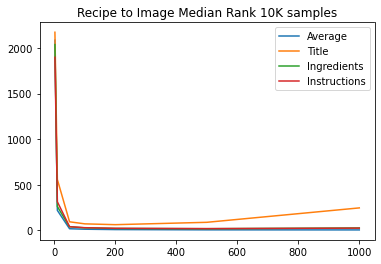

In [28]:
plt.plot(latent_dims,median_average,label='Average')
plt.plot(latent_dims,median_title,label='Title')
plt.plot(latent_dims,median_ingre,label='Ingredients')
plt.plot(latent_dims,median_instr,label='Instructions')
plt.legend()
plt.title("Recipe to Image Median Rank 10K samples")
plt.savefig('image_output/recipe2img_10k_samples.png')
plt.show()

In [9]:
ids=data[2]
chicken_lasagna_idx=np.where(ids == 'f79f91650c')[0][0]
lasagna_idx=np.where(ids == '003971cf31')[0][0]
salad_idx=np.where(ids == '001f8b08ac')[0][0]
chicken_salad_idx=np.where(ids == '09f70a1c31')[0][0]

In [50]:
filename='models/average_embeddings_img2text'+str(500)+'_model.pkl'
with open(filename, 'rb') as files:
    best_model= pickle.load(files)

In [52]:
data_transform=best_model.transform([data[0],data[1]])
data_transform[0].shape

(281598, 500)

In [53]:
chicken_lasagna_imgvec=data_transform[0][chicken_lasagna_idx]
lasagna_imgvec=data_transform[0][lasagna_idx]
salad_imgvec=data_transform[0][salad_idx]

In [54]:
chicken_lasagna_textvec=data_transform[1][chicken_lasagna_idx]
lasagna_textvec=data_transform[1][lasagna_idx]
salad_textvec=data_transform[1][salad_idx]

In [57]:
chicken_vec=np.subtract(chicken_lasagna_imgvec,lasagna_imgvec)
chicken_salad_vec=np.add(chicken_vec,salad_imgvec)

In [65]:
sims = np.dot(chicken_salad_vec,data_transform[1].T)
sorting = np.argsort(sims)[::-1].tolist()
ans_index=sorting[0]
ans_id=data[2][ans_index]
ans_id

'c4cbd0d736'

In [6]:
filename='models/title_embeddings_img2text'+str(200)+'_model.pkl'
with open(filename, 'rb') as files:
    best_model= pickle.load(files)

In [7]:
data_transform=best_model.transform([data[1],data[0]])
data_transform[0].shape

(281598, 200)

In [10]:
chicken_lasagna=data_transform[0][chicken_lasagna_idx]
lasagna=data_transform[0][lasagna_idx]
salad=data_transform[0][salad_idx]

In [11]:
chicken_vec=np.subtract(chicken_lasagna,lasagna)
chicken_salad_vec=np.add(chicken_vec,salad)

In [12]:
sims = np.dot(chicken_salad_vec,data_transform[1].T) # for recipe2im
sorting = np.argsort(sims)[::-1].tolist()
ans_index=sorting[0]
ans_id=data[2][ans_index]
ans_id

'c4cbd0d736'